In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [23]:
%cd /content/gdrive/My\ Drive/Posts/Neural \Style \Transfer

/content/gdrive/My Drive/Posts/Neural Style Transfer


In [72]:
import numpy as np
from tensorflow.keras.utils import get_file

import matplotlib.pyplot as plt

style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
base_url = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"


style_image_path = get_file(fname = "skyscraper.jpg", origin = style_transfer_url)
base_image_path = get_file(fname = "bilbao.jpg", origin = base_url)


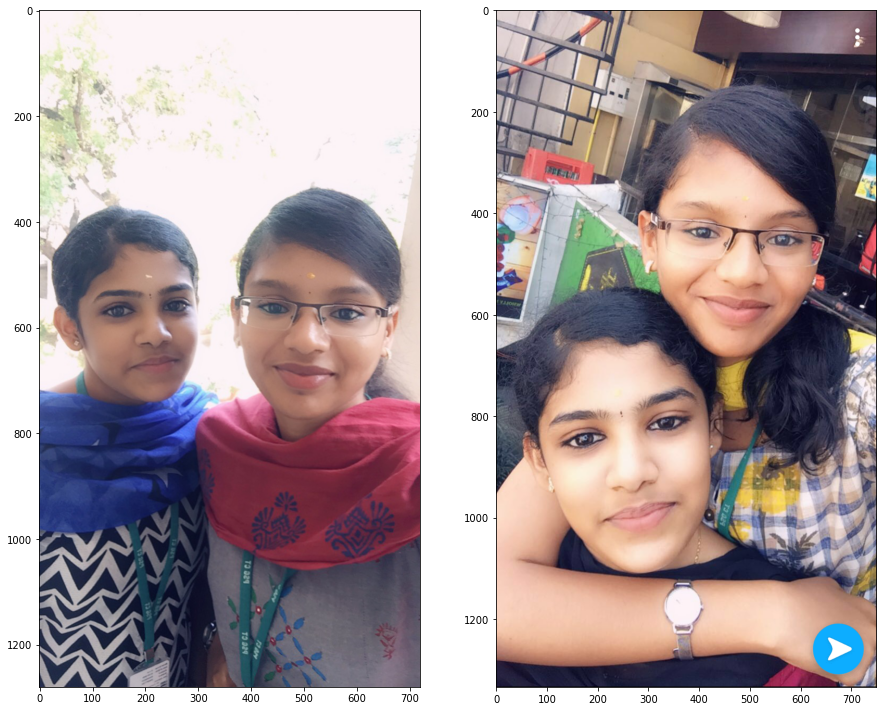

In [73]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read the image file in a numpy array
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()

In [74]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [75]:
def coste_estilo(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [76]:
def coste_contenido(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [77]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import plot_model


model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [78]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [79]:
capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

capas_contenido = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss

    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[capas_contenido]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * coste_contenido(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in capas_estilo:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = coste_estilo(style_reference_features, combination_features)
        loss += (style_weight / len(capas_estilo)) * sl

    return loss

In [80]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [81]:
import keras
from tensorflow.keras.applications import vgg19
import numpy as np


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [82]:
def deprocess_image(x):

    # Convertimos el tensor en Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [83]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

In [84]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import SGD
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 10

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=6406.43


In [85]:
combination_image

<tf.Variable 'Variable:0' shape=(1, 400, 225, 3) dtype=float32, numpy=
array([[[[142.37967  , 125.59748  , 128.70963  ],
         [141.60112  , 124.14088  , 128.08157  ],
         [142.57603  , 125.24748  , 129.15292  ],
         ...,
         [135.74547  , 110.77955  , 121.79338  ],
         [140.64896  , 119.48442  , 127.88506  ],
         [143.05305  , 125.05755  , 130.24187  ]],

        [[140.64824  , 122.99733  , 127.099205 ],
         [139.38548  , 121.016106 , 126.43777  ],
         [142.39043  , 124.80523  , 129.93944  ],
         ...,
         [138.9732   , 113.46475  , 128.80951  ],
         [139.21988  , 116.653244 , 129.10954  ],
         [141.71013  , 122.85745  , 130.33522  ]],

        [[140.63513  , 123.20063  , 127.51241  ],
         [139.27917  , 121.54472  , 127.14281  ],
         [143.80528  , 127.175545 , 132.27328  ],
         ...,
         [142.7884   , 123.60652  , 136.97807  ],
         [139.65057  , 121.00782  , 132.61496  ],
         [141.41837  , 124.14014 

In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
